# Notebook 1.A

## Synthetic data example: Regression

This is an oversimplified, synthetic example to illustrate basic concepts. It is a lot easier to understand concepts in very simple settings - this is the goal of this notebook

We want to use this simple example and learn about:
* Pytorch
* Simple Neural Networks
* Gradinet Descent (GD)
* Stochastic Gradient Descent (SGD)
* Empirical Risk Minimization

Not necessarily in this order though

In [1]:
# import pytorch
import torch
# imports for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np
import seaborn as sns
#%matplotlib notebook
sns.set_theme()
sns.set_style("darkgrid")

## Synthetic data
We assume our data is created by a pocess that can be described as:

<br><center>
$y(\boldsymbol{x}) = f(\boldsymbol{x}) + \epsilon$
</center>
where:
<br><center>
$f: \mathbb{R}^d \rightarrow \mathbb{R}$ $\quad$ and $\quad$ $\epsilon \sim \mathcal{N}(0, \sigma^2)$
</center><br>
I.e. we have some function $f$ that "produces" the observed data. But our observations are noisy. In our synthethic example the noise $\epsilon$ is normally distributed. Our goal now is to recover the "true" function $f$. 

<br>

> **_Note 1:_** In order to have an illustrative example we will set $d = 1$. Real world examples that are tackled by neural networks are typically of high dimensional nature ( $ d >> 1$).

> **_Note 2:_** The above noise assumption (standard normal distribution) is a very common one as we will see later

In [2]:
# Made up ground truth function
def f(x: torch.tensor) -> torch.tensor:
    f = torch.exp(0.001*x)*torch.sin(0.5*x)/x + torch.log(x) + torch.sin(0.1*x)
    return f

# This function generates the observations
def obs(x: torch.tensor) -> torch.tensor:
    fx = f(x)
    eps = torch.randn(len(x)) * 0.5
    y = fx + eps
    return y
    

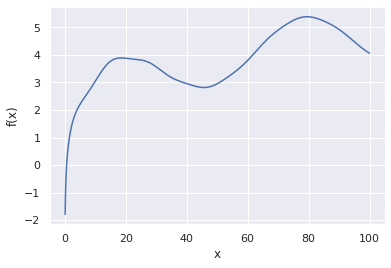

In [3]:
# evaluate true function values in the interval [0,100] on 1000 points
# This is the function f we do not actually know but want to learn
x = torch.linspace(0,100,1000)
fx = f(x)
# plot of our true function
plt.close()
plt.plot(x,fx)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

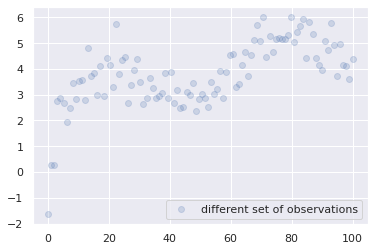

In [4]:
# We now create our observations.
# This are the values we get as dataset.
# Let's say we get samples measured at 100 positions x in the interval [0,100]
x = torch.linspace(0.1,100,100)
y = obs(x)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'o', label='observed data')

# for the sake of clarity we also plot the gorund truth function f
# Reminder: in reality we only would have the data points 
# Our goal is to recover f from the data
interval = torch.linspace(0,100,1000) 
fx = f(interval)
plt.plot(interval, fx, label='true function f')

# if we would draw again 100 samples from our process at the same positions, 
# we would get a different set of data points.
# Here we will plot a different set of observations as tranparent points
y_new = obs(x)
plt.close()
plt.plot(x, y_new, 'o', alpha=0.2, label='different set of observations')
plt.legend()
plt.savefig('/home/hubert/Lecture/Resources/data.svg')

So, let's repeat the setting and connect it to the notation that we introduced in the slides:
* We are given a dataset of 100 i.i.d. featur-response pairs $~ \mathcal{D} = \{(~ y_i, ~ x_i~)\}_{i=1}^{100} ~$
* We want to recover the real underlying function $f$
* We assume (and in this case we know) that the noise is a standard normally distributed random variable: $\epsilon \sim \mathcal{N}(0, 1)$
* Thus, for a given value $\hat{x}$ the observation is a random variable distributed as $\hat{y} \sim \mathcal{N}(f(\hat{x}), 1)$

For clarity we again visualize the dataset $\mathcal{D}$ below

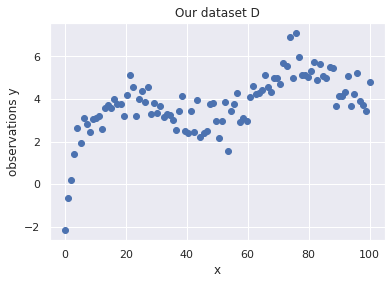

In [5]:
x = torch.linspace(0.1,100,100)
plt.close()
plt.title('Our dataset D')
plt.xlabel('x')
plt.ylabel('observations y')
plt.plot(x, y, 'o')

## Learning a model function $g$

Now we want to learn a model $g$ that recovers the real underlying function $f$ as good as possible. The important part here is, that this should also be true for inputs $x$ that are not in the dataset!


> **_Note:_** "Recover the real underlying function" is just a different way to say: if somebody gives us a new $x$ that was not part of our datast, we should be able to return the right response $f(x)$. In our case we know exactly what the right response for any given $x$ is, because we know the true function $f$. But in real live we don't have this function. So how do we know how good our model function $g$ is? This will soon be treated under the name of "generalization"


#### Loss function
 Our next step is to define a loss function $\mathcal{\ell}: \mathbb{R} \rightarrow \mathbb{R}_+$. The loss function should meassure how well our model $g$ performs. Since we pretend to do not know the real function, we can only evaluate this function on points of our dataset $\mathcal{D}$. The loss function is a mapping into the positive real domain. The function is only $0$ if For a given tuple $(y, x)$ our prediction equals the ground truth.  


A typical loss function for regression is the so called _**Mean Squared Error**_ (MSE). Here, the loss function is the squared error between ground truth and prediction. The MSE is simply the expected value of the squared error:

</br><center>
    $\mathcal{\ell}(~y,~g(~x)) = (~ y_i - g(~x_i)~)^2$
</center>       
</br><center>
$\text{MSE} = \mathbb{E}[\mathcal{\ell}(~y,~g(~x))] = \frac{1}{N} \sum_{i=1}^N (~ y_i - g(~x_i)~)^2$
</center>

> **_Note:_** For now it looks like this loss function arises out of nowhere. Later we will see that this is actually the right loss function in case of normally distributed noise.


Below we implement the loss function.

In [6]:
# Implementation of the MSE loss function
def MSE(y: torch.tensor, gx: torch.tensor) -> torch.tensor:
    delta = y - gx
    delta_sq = delta * delta
    mse = delta_sq.mean()
    return mse

#### A simple model g

Since we have no idea how the true function $f$ looks like, we have no other choice then to come up with a model function $g$ ourselfs. As a first gues we could ignore the obvious nonlinearity in the data and use a linear model function. 

> **_Note:_** In the linear case there exists an optimal solution. You can read that up here: https://en.wikipedia.org/wiki/Simple_linear_regression


For the sake of this lecture, we ignore that there is already an optimal solution for the linear case (in the real world pleas do not do that!!!). Rather, we use this example to learn about:
* Pytorch
* Gradinet Descent (GD)
* Stochastic Gradient Descent (SGD)
* Empirical Risk Minimization
* Simple Neural Networks

Everything we will understand here will be helpfull later.

<br>
Linear means that we assume our data is generated by a function $g_l$ of the form:

<br><center>
    $y(x) = g_l(x) + \epsilon$
</center>

with

<br><center>
        $g_l(x) = wx + b, \quad w,b \in \mathbb{R}$ 
</center>

I.e. we try to find a straight line that best explains the data. Here, $w$ is the slope and $b$ the offset of this straight line. However, we will call $w$ the "weight" and $b$ the "bias". Next we implement this linear model as PyTorch module.


In [7]:
# all our future models will be derived from torch.nn.Module
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(LinearModel, self).__init__()
        # create a linear mapping Wx + b 
        self.linear = torch.nn.Linear(in_features=input_dim, out_features=output_dim)
    
    # every Module has a forward method that is called via the __call__ method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # apply linear mapping
        # Linear is derived from Module as well.
        # Internally we call Linears forward method
        out = self.linear(x)
        return out

In [8]:
# Let's instantiate a model function
g = LinearModel(input_dim=1, output_dim=1)

# When intantiated w and b are randomly initialized
# The following code prints the values for w and b
print(f'Initialized value of w: {g.linear.weight}')
print('----------------------------------------')
print(f'Initialized value of b: {g.linear.bias}')

Initialized value of w: Parameter containing:
tensor([[-0.1682]], requires_grad=True)
----------------------------------------
Initialized value of b: Parameter containing:
tensor([0.0529], requires_grad=True)


In [9]:
# now let's perform a 'forward pass', i.e. applying the function to our data
out = g(x.view(-1,1))

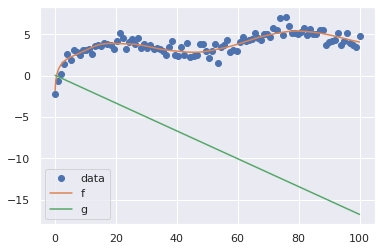

In [10]:
# we plot the data, the original function and and our model function
plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
plt.show()

In [11]:
g.linear.weight.data

tensor([[-0.1682]])

clearly, using a random weight and bias leads to very bad estimate. So, lets "learn" the parameters w, b in order to get a better linear model function.

In [12]:
g.linear.weight.data = torch.tensor([[1.]])
g.linear.bias.data = torch.tensor([[-2.]])

In [13]:
n_epoch = 50000
lr = 2.5e-4
loss_array = []
fx_dist = []
w_array = []
b_array = []
for epoch in range(n_epoch):
    # set all gradients to zero
    g.zero_grad()
    
    # store current params
    w_array.append(g.linear.weight.data.item())
    b_array.append(g.linear.bias.data.item())
    
    # calculate g(x_i) for all x_i at once
    out = g(x.view(-1,1))
    
    # calculate the mean squared loss 
    loss = MSE(y=y, gx=out.view(-1))
    
    # calculate gradients
    loss.backward()
    
    # store gradients into variables (for better readability) 
    dw = g.linear.weight.grad
    db = g.linear.bias.grad
    
    # change weights along steepest descent scaled by a "learning rate"
    g.linear.weight.data -= lr*dw
    g.linear.bias.data -=  lr*db
    
    # store losses for visualization of training curve
    loss_array.append(loss.item())
    
    # compute mean absolute distance to f and save it into array
    with torch.no_grad():
            fx_ = f(x.view(-1,1))
            fx_dist.append( (fx_ - out).abs().mean())
    
    
    if epoch % 1000 == 0:
        print(f'\r[{epoch+1}/{n_epoch}]: loss = {loss}', end="")

print(g.linear.weight)
print(g.linear.bias)

[49001/50000]: loss = 1.1717276573181152Parameter containing:
tensor([[0.0290]], requires_grad=True)
Parameter containing:
tensor([[2.3245]], requires_grad=True)


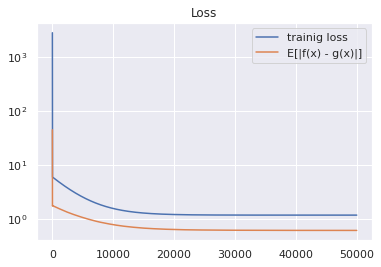

In [14]:
plt.close()
plt.yscale('log')
plt.title('Loss')
plt.plot(loss_array, label='trainig loss')
plt.plot(fx_dist, label='E[|f(x) - g(x)|]')
plt.legend()
plt.show()

(15, 15)
(15, 15)
torch.Size([15, 15])


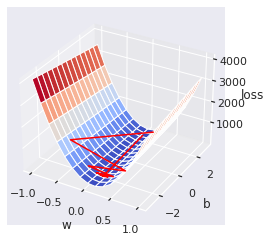

In [15]:
# %matplotlib notebook
W, B = np.meshgrid(
    torch.linspace(
        min(-1,min(w_array)),max(1,max(w_array)),15).detach(), 
    torch.linspace(
        min(-3,min(b_array)),max(3,max(b_array)),15).detach())
Z = ((((torch.tensor(W[None]) * x[...,None,None]) + B[None]) - y[...,None,None])**2).mean(0)
print(W.shape)
print(B.shape)
print(Z.shape)
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(w_array,#[::100], 
        b_array,#[::100], 
        loss_array,#[::100], 
        color='red')
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')
ax.plot_surface(W, B, Z.detach(), cmap=cm.coolwarm)
#plt.show()
# plt.savefig('/home/hubert/Lecture/Resources/grad_desc.svg')

(15, 15)
(15, 15)
torch.Size([15, 15])


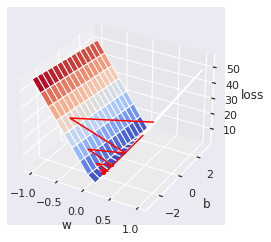

In [16]:
# %matplotlib notebook
fx_ = f(x.view(-1,1)).squeeze()
W, B = np.meshgrid(
    torch.linspace(
        min(-1,min(w_array)),max(1,max(w_array)),15).detach(), 
    torch.linspace(
        min(-3,min(b_array)),max(3,max(b_array)),15).detach())
Z = ((((torch.tensor(W[None]) * x[...,None,None]) + B[None]) - fx_[...,None,None]).abs()).mean(0)
print(W.shape)
print(B.shape)
print(Z.shape)
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(w_array,#[::100], 
        b_array,#[::100], 
        fx_dist,#[::100], *
        color='red')
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')
ax.plot_surface(W, B, Z.detach(), cmap=cm.coolwarm)
plt.show()
#plt.savefig('/home/hubert/Lecture/Resources/grad_desc.svg')

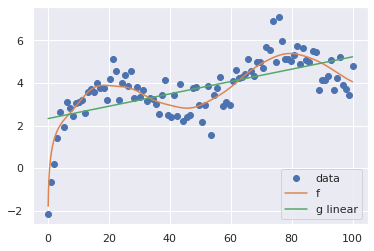

In [18]:
# we plot the data, the original function and and our model function
out = g(x.view(100,1))
plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g linear')
plt.legend()
# plt.show()
# plt.savefig('/home/hubert/Lecture/Resources/liear_fit.svg')

We see, that the learned linear model fits the data quite well. However, there might be a better, more complex model. Lets make our model non linear and deeper!

In [19]:
class NonLinearModel(torch.nn.Module):
    def __init__(self, input_dim: int, intermediate_dim: int, output_dim: int) -> None:
        super(NonLinearModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=input_dim, out_features=intermediate_dim)
        self.linear2 = torch.nn.Linear(in_features=intermediate_dim, out_features=output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # apply linear mapping
        x = self.linear1(x)
        # apply pointwise nonlinearity
        # x = torch.sigmoid(x)
        # x = torch.tanh(x)
        x = torch.relu(x)
        
        # apply linear mapping
        out = self.linear2(x)
        return out

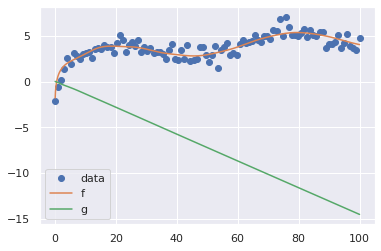

In [20]:
# Let's instantiate the new model function
net = NonLinearModel(input_dim=1, intermediate_dim=2000, output_dim=1)

# and lets apply the function on our data and plot it
out = net(x.view(-1,1))

plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
plt.show()

In [21]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.0001)
n_epoch = 100000
loss_array = []
fx_dist = []
for epoch in range(n_epoch):
    # set all gradients to zero
    net.zero_grad()
    
    # apply neural network on all data points
    out = net(x.view(100,1))
    
    # calculate loss
    loss = MSE(y=y, gx=out.view(-1))
    
    # calculate gradients
    loss.backward()
    
    # one step along the steppest descent
    optimizer.step()
    
    # store loss vor visualization
    loss_array.append(loss.item())
    
    # compute mean absolute distance to f and save it into array
    with torch.no_grad():
            fx_ = f(x.view(-1,1))
            fx_dist.append( (fx_ - out).abs().mean())
    
    if epoch % 1000 == 0:
        print(f'\r[{epoch+1}/{n_epoch}]: loss = {loss}', end='')

[99001/100000]: loss = 0.6585018634796143

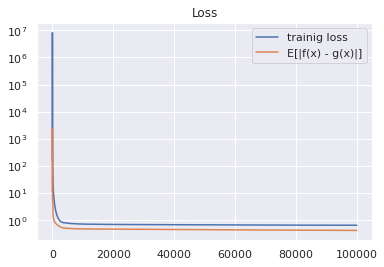

In [22]:
plt.close()
plt.yscale('log')
plt.title('Loss')
plt.plot(loss_array, label='trainig loss')
plt.plot(fx_dist, label='E[|f(x) - g(x)|]')
plt.legend()
plt.show()

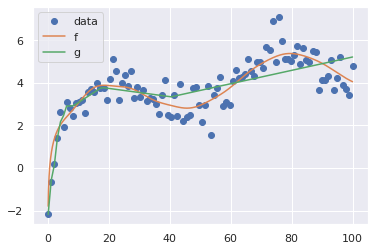

In [23]:
# and lets apply the function on our data and plot it
out = net(x.view(100,1))
plt.close()
plt.plot(x, y, 'o', label='data')
plt.plot(interval, fx, label='f')
plt.plot(x, out.detach().squeeze(), label='g')
plt.legend()
#plt.show()
# plt.savefig('/home/hubert/Lecture/Resources/relu_result.svg')

In [24]:
# implement plotting functions
def plot_fun(x: torch.Tensor, f, title='', save_at = None) -> None:
    # plot function
    plt.close()
    fx = f(x)
    plt.plot(x,f(x))
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(title)
    
    # plot coord
    border = 0.1*(max(fx) - min(fx))
    plt.ylim([min(fx) - border, max(fx) + border])
    plt.xlim([min(x), max(x)])
    plt.plot(x, x*0, 'k')
    plt.plot([0,0],[min(fx) - border,max(fx) + border] , 'k')
    if save_at is not None:
        plt.savefig(save_at)

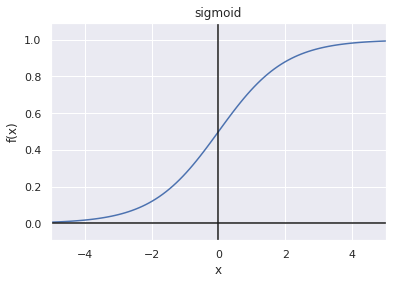

In [25]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.sigmoid, title='sigmoid')

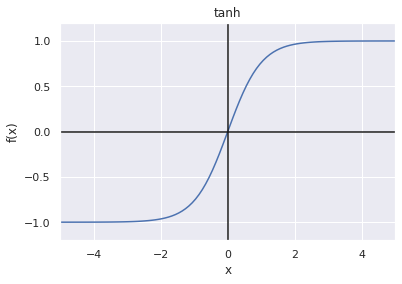

In [26]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.tanh, title='tanh')

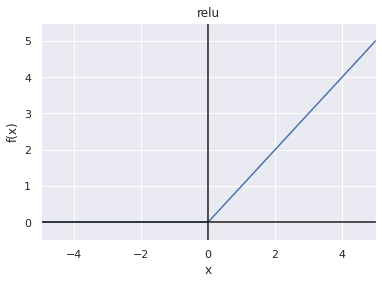

In [27]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.relu, title='relu')

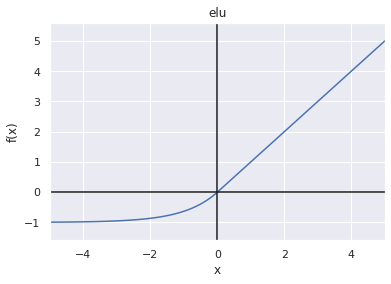

In [28]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.nn.ELU(), title='elu')

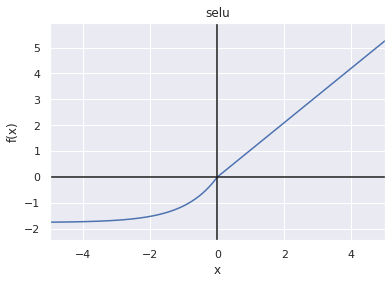

In [29]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.nn.SELU(), title='selu')

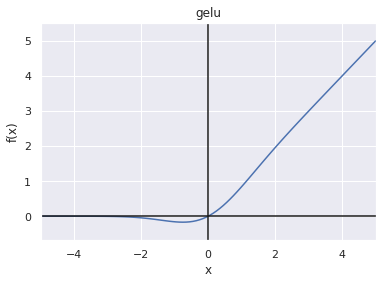

In [30]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.nn.GELU(), title='gelu')

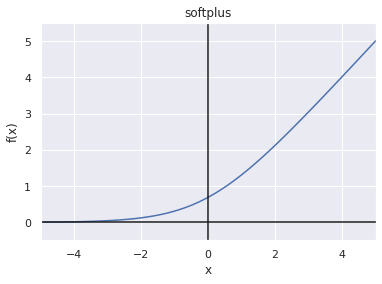

In [31]:
xxx = torch.linspace(-5,5,100)
yyy = torch.sigmoid(xxx)
plot_fun(xxx,torch.nn.Softplus(), 'softplus')